
##    Target
1.   First Step in achieving the goal is have a lighter Model.It is not possible to reach the model in one step, but here we take initial step.
2.   Replace large Kernel is last layer with GAP , it helps reducing parameters
4.   Prefer a model that is not overfitting and can be imroved by applying hyperparameter tuning in later steps.

##    Results:  

1.   Parameters: 9.3k
2.   Best Train Accuracy: 98.86
3.   Best Test Accuracy: 98.98

##    Analysis (Please refer to Plot and Model Summary):

1.   Good model!
2.   No Overfitting. This model has potential to improve !!
 


# Import Libraries

In [16]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

Normalize and convert to Tensor.
 
Data is already 28X28, hence no resizing needed


In [17]:
# Train Phase transformations
train_transforms = transforms.Compose([                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([                                     
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [18]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [19]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Define the Model

In [20]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()            
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 6

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),           
        ) 
       

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Display Model parameters

In [21]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,304
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 10, 24, 24]             160
         MaxPool2d-6           [-1, 10, 12, 12]               0
            Conv2d-7           [-1, 14, 10, 10]           1,260
              ReLU-8           [-1, 14, 10, 10]               0
            Conv2d-9             [-1, 14, 8, 8]           1,764
             ReLU-10             [-1, 14, 8, 8]               0
           Conv2d-11             [-1, 14, 6, 6]           1,764
             ReLU-12             [-1, 14, 6, 6]               0
           Conv2d-13             [-1, 14, 6, 6]           1,764
             ReLU-14             [

# Training and Testing

Use **tqdm** progressbar to get visual logs. 


In [22]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # reset grad after each batch
   
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    tqdm._instances.clear()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test the model

In [23]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=2.301988363265991 Batch_id=468 Accuracy=9.93: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3022, Accuracy: 1032/10000 (10.32%)

EPOCH: 2


Loss=1.8571325540542603 Batch_id=468 Accuracy=12.28: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8457, Accuracy: 3150/10000 (31.50%)

EPOCH: 3


Loss=0.552154004573822 Batch_id=468 Accuracy=85.12: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1974, Accuracy: 9366/10000 (93.66%)

EPOCH: 4


Loss=0.09993701428174973 Batch_id=468 Accuracy=95.17: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0963, Accuracy: 9718/10000 (97.18%)

EPOCH: 5


Loss=0.06917433440685272 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9763/10000 (97.63%)

EPOCH: 6


Loss=0.04817090556025505 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9770/10000 (97.70%)

EPOCH: 7


Loss=0.05817968770861626 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9801/10000 (98.01%)

EPOCH: 8


Loss=0.11732617765665054 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9844/10000 (98.44%)

EPOCH: 9


Loss=0.10757417231798172 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9800/10000 (98.00%)

EPOCH: 10


Loss=0.09111067652702332 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9827/10000 (98.27%)

EPOCH: 11


Loss=0.043531015515327454 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9853/10000 (98.53%)

EPOCH: 12


Loss=0.10948100686073303 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9875/10000 (98.75%)

EPOCH: 13


Loss=0.13563628494739532 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9860/10000 (98.60%)

EPOCH: 14


Loss=0.03866631165146828 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9881/10000 (98.81%)

EPOCH: 15


Loss=0.05043685808777809 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]



Test set: Average loss: 0.0330, Accuracy: 9898/10000 (98.98%)



# Plot the result

Text(0.5, 1.0, 'Test Accuracy')

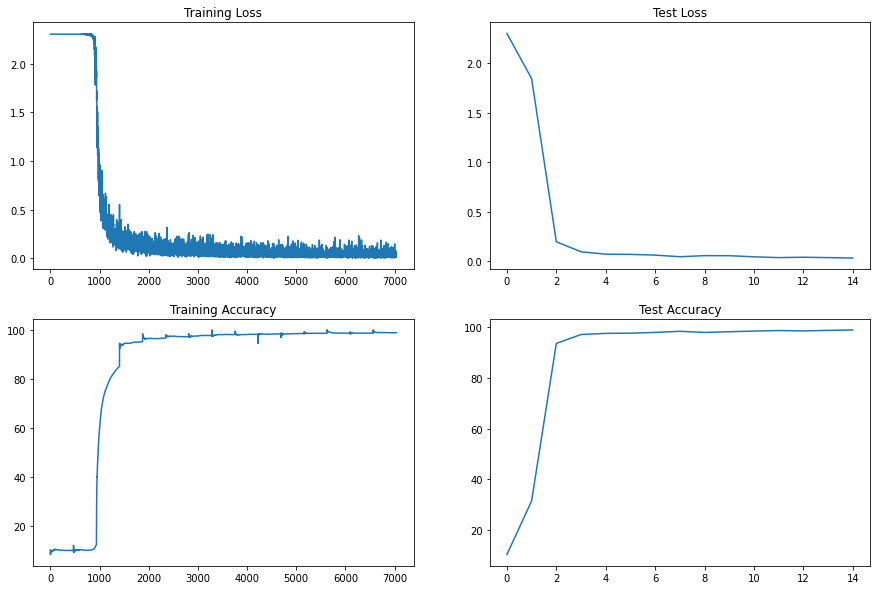

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")